In [1]:
%matplotlib inline

from PIL import Image
from matplotlib import pyplot as plt
from matplotlib.pyplot import imshow
import numpy as np

In [2]:
# Image path
file_path = 'data/img04g.tif'

In [3]:
im = Image.open(file_path)
imarray = np.array(im) 

imarray = imarray[:200, :200]
print("The size of the input figure is: ", imarray.shape) 

The size of the input figure is:  (200, 200)


In [4]:
# Parameters

# image size
imgHeight = imarray.shape[0]
imgWidth = imarray.shape[1]

# display size
sHeight = imgHeight/40
sWidth = imgWidth/40

# gaussian white noise
nMean = 0
nStd = 8
nVariance = nStd ** 2

# gaussian noncausal prediction filter
g_filter = np.asarray([
    [1/12, 1/6, 1/12],
    [1/6, 0, 1/6],
    [1/12, 1/6, 1/12],
])

# other parameters
rho = 100
alpha_param = 0.5

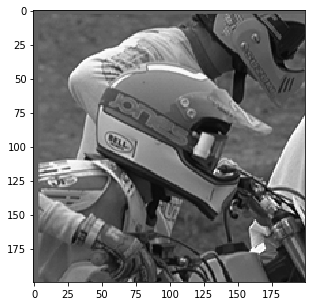

In [5]:
plt.figure(figsize = (sHeight, sWidth))
plt.imshow(imarray, cmap=plt.get_cmap('gray'))

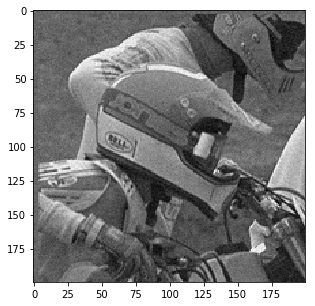

In [6]:
# Add Guassian Noise.
noisy_img = imarray + (np.random.randn(imarray.shape[0], imarray.shape[1]) * nStd + nMean)
plt.figure(figsize = (sHeight, sWidth))
plt.imshow(noisy_img, cmap=plt.get_cmap('gray'))

In [7]:
def calculate_prediction_variance(x, g_filter, p=2):
  """
  x: 2d image
  g_filter: 3*3 filter
  """

  sigmaP_sum = []
  for i in range(1, x.shape[0] - 1):
    for j in range(1, x.shape[1] - 1):

      x_center = x[i, j]
      for pi in range(3):
        for pj in range(3):
          x_neighbor = x[i + pi - 1, i + pj - 1]
          sigmaP_sum.append(g_filter[pi, pj] * np.abs(x_center - x_neighbor) ** p)

  return np.mean(sigmaP_sum)

In [8]:
variance_x = calculate_prediction_variance(noisy_img, g_filter)
variance_x

484.1126284417205

In [9]:
def calculate_bar(Z):
  """
  Z: height * width * 3 * 3 matrix
  """

  height = Z.shape[0]
  width = Z.shape[1]
  z_consensus = np.zeros((height, width))
  for vi in range(height):
    for vj in range(width):
      v_sum = 0
      for pi in range(3):
        for pj in range(3):
          v_sum += Z[
            (vi + pi - 1 + height) % height, (vj + pj - 1 + width) % width,
            2 - pi, 2 - pj
          ]
      z_consensus[vi, vj] = v_sum / 9

  return z_consensus

In [10]:
def consensus_project_voxel(Z):
  """
  Z: height * width * 3 * 3 matrix
  """

  height = Z.shape[0]
  width = Z.shape[1]

  x = np.zeros(Z.shape)
  z_consensus = calculate_bar(Z)

  for vi in range(height):
    for vj in range(width):
      for pi in range(3):
        for pj in range(3):
          x[vi, vj, pi, pj] = z_consensus[
            (vi + pi - 1 + height) % height,
            (vj + pj - 1 + width) % width
          ]

  return x

In [11]:
# Calculate some coefficients

alpha = np.sum(g_filter ** 2 / (g_filter + variance_x / rho))
alpha = alpha / variance_x

gamma = 1 / variance_x + 1 / nVariance + 1 / rho

beta = g_filter / (g_filter * rho + variance_x)
beta = np.reshape(beta, (beta.shape[0] * beta.shape[1], 1))  # row first

phi = variance_x / (g_filter * rho + variance_x)
phi = np.reshape(phi, (phi.shape[0] * phi.shape[1], 1))  # row first

In [12]:
print(" ****** PARAMETERS ****** ")
print("alpha = {}".format(alpha))
print("gamma = {}".format(gamma))
print("beta = {}".format(beta))
print("phi = {}".format(phi))

 ****** PARAMETERS ****** 
alpha = 5.748335406015371e-05
gamma = 0.02769063502220307
beta = [[0.00016922]
 [0.00033281]
 [0.00016922]
 [0.00033281]
 [0.        ]
 [0.00033281]
 [0.00016922]
 [0.00033281]
 [0.00016922]]
phi = [[0.98307767]
 [0.96671854]
 [0.98307767]
 [0.96671854]
 [1.        ]
 [0.96671854]
 [0.98307767]
 [0.96671854]
 [0.98307767]]


In [13]:
z = np.random.randint(0, 255, (imgHeight, imgWidth, g_filter.shape[0], g_filter.shape[1]))
# z = np.repeat(noisy_img[:, :, np.newaxis], 3, axis=-1)
# z = np.repeat(z[:, :, :, np.newaxis], 3, axis=-1)
x_hat = np.zeros((imgHeight, imgWidth, g_filter.shape[0], g_filter.shape[1]))

z_entries_num = imgHeight * imgWidth * g_filter.shape[0] * g_filter.shape[1]

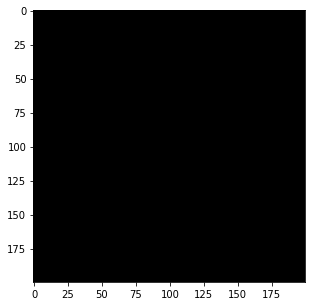

In [14]:
x_display = x_hat[:, :, 1, 1]
plt.figure(figsize = (sHeight, sWidth))
plt.imshow(x_display, cmap=plt.get_cmap('gray'))

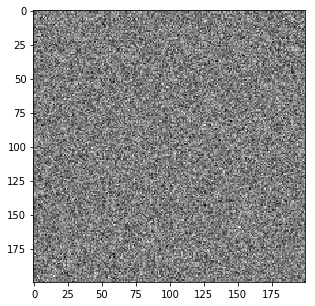

Epoch 0, the difference between z (square sum): 1543692183
Epoch 0, the difference between z (averaged value): 0.10913846762595095
Epoch 1, the difference between z (square sum): 45392390
Epoch 1, the difference between z (averaged value): 0.01871496521074795
Epoch 2, the difference between z (square sum): 25617959
Epoch 2, the difference between z (averaged value): 0.014059496318445946
Epoch 3, the difference between z (square sum): 18604844
Epoch 3, the difference between z (averaged value): 0.011981481338370827
Epoch 4, the difference between z (square sum): 15003186
Epoch 4, the difference between z (averaged value): 0.010759429542223605
Epoch 5, the difference between z (square sum): 12188166
Epoch 5, the difference between z (averaged value): 0.009697653878167685
Epoch 6, the difference between z (square sum): 9602802
Epoch 6, the difference between z (averaged value): 0.008607885596616885
Epoch 7, the difference between z (square sum): 7285585
Epoch 7, the difference between z (

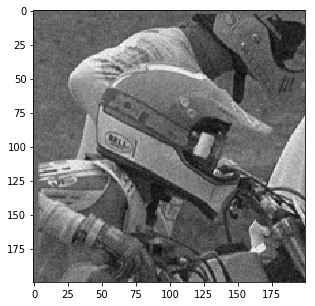

Epoch 10, the difference between z (square sum): 2622277
Epoch 10, the difference between z (averaged value): 0.004498179501438387
Epoch 11, the difference between z (square sum): 1783067
Epoch 11, the difference between z (averaged value): 0.0037092092182419902
Epoch 12, the difference between z (square sum): 1201888
Epoch 12, the difference between z (averaged value): 0.003045295906885541
Epoch 13, the difference between z (square sum): 803479
Epoch 13, the difference between z (averaged value): 0.0024899163925672903
Epoch 14, the difference between z (square sum): 535100
Epoch 14, the difference between z (averaged value): 0.002031959159208511
Epoch 15, the difference between z (square sum): 359092
Epoch 15, the difference between z (averaged value): 0.0016645634878064192
Epoch 16, the difference between z (square sum): 245929
Epoch 16, the difference between z (averaged value): 0.0013775341406447883
Epoch 17, the difference between z (square sum): 171726
Epoch 17, the difference be

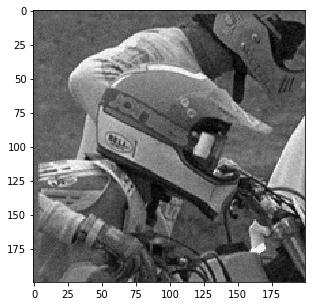

Epoch 20, the difference between z (square sum): 64514
Epoch 20, the difference between z (averaged value): 0.0007055446193378156
Epoch 21, the difference between z (square sum): 45597
Epoch 21, the difference between z (averaged value): 0.0005931515014763966
Epoch 22, the difference between z (square sum): 32051
Epoch 22, the difference between z (averaged value): 0.0004972998077271215
Epoch 23, the difference between z (square sum): 21872
Epoch 23, the difference between z (averaged value): 0.00041081070105191444
Epoch 24, the difference between z (square sum): 14386
Epoch 24, the difference between z (averaged value): 0.00033317125689313757
Epoch 25, the difference between z (square sum): 9137
Epoch 25, the difference between z (averaged value): 0.0002655212669634516
Epoch 26, the difference between z (square sum): 5497
Epoch 26, the difference between z (averaged value): 0.00020594932254511088
Epoch 27, the difference between z (square sum): 3090
Epoch 27, the difference between z 

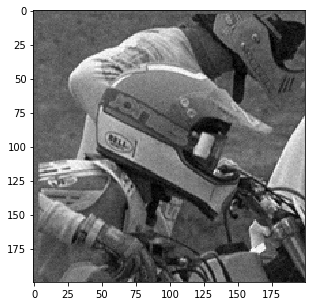

Epoch 30, the difference between z (square sum): 435
Epoch 30, the difference between z (averaged value): 5.793514892948392e-05
Epoch 31, the difference between z (square sum): 226
Epoch 31, the difference between z (averaged value): 4.1759156606591415e-05
Epoch 32, the difference between z (square sum): 115
Epoch 32, the difference between z (averaged value): 2.978834804101002e-05
Epoch 33, the difference between z (square sum): 56
Epoch 33, the difference between z (averaged value): 2.0786985482077453e-05
Epoch 34, the difference between z (square sum): 15
Epoch 34, the difference between z (averaged value): 1.075828707279838e-05
Epoch 35, the difference between z (square sum): 5
Epoch 35, the difference between z (averaged value): 6.211299937499416e-06
Epoch 36, the difference between z (square sum): 2
Epoch 36, the difference between z (averaged value): 3.928371006591931e-06
Epoch 37, the difference between z (square sum): 0
Epoch 37, the difference between z (averaged value): 0.0


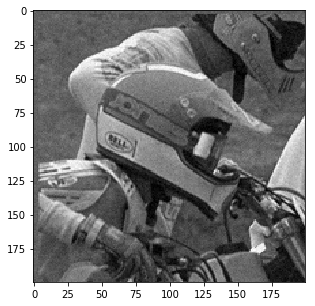

Epoch 40, the difference between z (square sum): 0
Epoch 40, the difference between z (averaged value): 0.0
Epoch 41, the difference between z (square sum): 0
Epoch 41, the difference between z (averaged value): 0.0
Epoch 42, the difference between z (square sum): 0
Epoch 42, the difference between z (averaged value): 0.0
Epoch 43, the difference between z (square sum): 0
Epoch 43, the difference between z (averaged value): 0.0
Epoch 44, the difference between z (square sum): 0
Epoch 44, the difference between z (averaged value): 0.0
Epoch 45, the difference between z (square sum): 0
Epoch 45, the difference between z (averaged value): 0.0
Epoch 46, the difference between z (square sum): 0
Epoch 46, the difference between z (averaged value): 0.0
Epoch 47, the difference between z (square sum): 0
Epoch 47, the difference between z (averaged value): 0.0
Epoch 48, the difference between z (square sum): 0
Epoch 48, the difference between z (averaged value): 0.0
Epoch 49, the difference bet

In [15]:
epoch_num = 50

for epoch_i in range(epoch_num):

  x_hat = consensus_project_voxel(z)

  x_hat[x_hat > 255] = 255
  x_hat[x_hat < 0] = 0

  z_memory = z.copy()

  if not epoch_i % 10:
    x_display = x_hat[:, :, 1, 1]
    plt.figure(figsize=(sHeight, sWidth))
    plt.imshow(x_display, cmap=plt.get_cmap('gray'))
    plt.show()

  for pi in range(imgHeight):
    for pj in range(imgWidth):
      z_i = z[pi, pj, :, :]
      prox_point = 2 * x_hat[pi, pj] - z_i
      prox_point_vec = np.reshape(prox_point, (prox_point.shape[0] * prox_point.shape[1], 1))

      x_i = 1 / (gamma - alpha) * (1 / nVariance * noisy_img[pi, pj] +
                                   1 / rho * prox_point_vec[4] + np.matmul(beta.T, prox_point_vec))
      x_j_vec = rho * x_i * beta + phi * prox_point_vec
      x_vec = np.reshape(x_j_vec, (prox_point.shape[0], prox_point.shape[1]))
      x_vec[1, 1] = x_i

      z_update = z_i + 2 * alpha_param * (x_vec - x_hat[pi, pj])

      z[pi, pj] = z_update

  print("Epoch {}, the difference between z (square sum): {}".format(
    epoch_i,
    (np.sum((z - z_memory) ** 2))
  )
  )
  print("Epoch {}, the difference between z (averaged value): {}".format(
    epoch_i,
    (np.sum((z - z_memory) ** 2)) ** 0.5 / z_entries_num
  )
  )

In [16]:
z_memory[:, :, 1, 1]

array([[ 91, 100,  95, ..., 113,  88,  92],
       [ 79, 114,  97, ..., 111,  95,  76],
       [ 88,  91, 110, ...,  92,  99,  97],
       ...,
       [ 97, 104,  95, ...,  21,  20,  33],
       [108,  80, 107, ...,  20,  24,  28],
       [ 96, 102,  91, ...,  26,   9,  22]])

In [17]:
z[:, :, 1, 1]

array([[ 91, 100,  95, ..., 113,  88,  92],
       [ 79, 114,  97, ..., 111,  95,  76],
       [ 88,  91, 110, ...,  92,  99,  97],
       ...,
       [ 97, 104,  95, ...,  21,  20,  33],
       [108,  80, 107, ...,  20,  24,  28],
       [ 96, 102,  91, ...,  26,   9,  22]])

In [18]:
x_hat_int = x_hat[:, :, 1, 1].astype(np.int16)
x_hat_int[10:20, 10:20]

array([[ 96,  93,  88,  92,  90,  97,  82,  76,  93,  95],
       [100,  89,  89,  84,  95,  90,  96,  89,  95,  87],
       [105,  84,  92, 107,  91,  99,  85,  98,  92,  93],
       [106,  94,  90,  93,  87, 101,  98,  91,  98,  95],
       [101, 103,  89,  89,  94,  96,  91,  87,  83,  99],
       [ 90, 100,  99,  99,  89,  97,  87,  88,  90,  87],
       [ 96,  91,  97,  99,  94,  92,  93,  88,  88,  94],
       [102,  94,  86,  96,  89, 106, 102, 101, 103,  92],
       [ 98,  93,  98,  87,  86,  82,  92,  95,  98,  96],
       [ 94,  98, 101,  95,  96,  92,  97,  87,  97,  93]], dtype=int16)

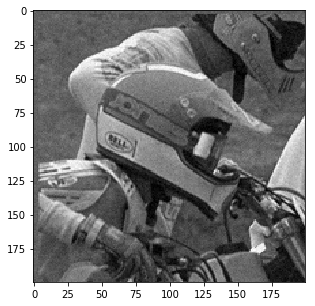

In [19]:
x_display = x_hat[:, :, 1, 1]
plt.figure(figsize = (sHeight, sWidth))
plt.imshow(x_display, cmap=plt.get_cmap('gray'))
plt.show()